# Baseline Implicit Desolvation Implementation

(From Alford et al with revisions):

Rosetta utilizes an implicit solvation model combining both isotropic and
anisotropic components.

The isotropic (LK) desolvation component is an gaussian exclusion model
$f_{desolv}$, derived from [Lazaridis, Karplus'99]
(https://www.ncbi.nlm.nih.gov/pubmed/10223287), describing the energy
required to desolvate an atom $i$ when it is approached by a neighboring atom
$j$. In contrast to the original model, the $ΔG^{ref}$ term is removed in favor
of explict per-residue reference energies.

The energy of the atom-pair interaction varies with:

* Separation distance: $d_{i,j}$.
* Atomic radius: $r_{i}$
* Experimentally determined vapor-to-water transfer free energy: $ΔG^{free}_i$
* Correlation length: $λ_i$
* Atomic volume of the desolvating atom: $V_j$

With a functional form:

$$
f_{desolv} =
    -V_j \frac{ΔG^{free}_i}{2\pi^{3/2} \lambda_i d_{i,j}^2}
    \exp \left[- \left(\frac{d_{i,j} - {r}_{i}}{\lambda_i}\right)^2 \right]
$$

To accomodate softened repulsive potentials (which otherwise prevent overlapping atomic radii) and reduced hbond donor/acceptor $\sigma_{i,j}$ the potential is defined as a constant for $d_{i,j} < .89 {\sigma}_{i,j}$. To accomodate efficient truncated evaluation, the potential is defined as 0 for $d_{i,j} >= 6Å$. Cubic polynomial interpolation $f_{cpoly}$ is used to smoothly transition between these regions.

For a final piecewise definition:

$$
fa\_sol_{i,j}\left(d_{i,j} \right) =  w_{i,j}^{conn} \cdot \left\{
\begin{array}{ll}
  f_{desolv}(d_{min}) &
      d_{i,j} \in [ 0Å, d_{min} - c ) \\
  f_{cpoly\_low}(d_{i,j}) &
      d_{i,j} \in [ d_{min} - c, d_{min} + c ) \\
  f_{desolv}(d_{i,j}) &
      d_{i,j} \in [ {\sigma}_{i,j} + c, 4.5Å ) \\
  f_{cpoly\_hi}(d_{i,j}) &
      d_{i,j} \in [ 4.5Å, 6.0Å ) \\
  0 &
      d_{i,j} \in [ 6.0Å, +\infty ) \\
\end{array}
\right|
\begin{array}{ll}
  d_{min} = 0.89 {\sigma}_{i,j} ~,~ c = 0.25 Å \\
  f_{cpoly\_low} = f_{desolv}(d_{min}) ~,~ f^\prime_{cpoly\_{low}} = f^\prime_{desolv}(d_{min}) \left|~ d = (d_{min} - c) \right. \\
  f_{cpoly\_low} = f_{desolv} ~,~ f^\prime_{cpoly\_{low}} = f^\prime_{desolv} \left|~ d = (d_{min} + c) \right. \\
  f_{cpoly\_hi} = f_{desolv} ~,~ f^\prime_{cpoly\_{hi}} = f^\prime_{desolv} \left|~ d = 4.5Å \right. \\
  f_{cpoly\_hi} = f^\prime_{cpoly\_{hi}} = 0 \left|~ d = 6.0Å \right. \\
\end{array}
$$

In [1]:
import numpy
from matplotlib import pylab

from tmol.score.ljlk.numba.vectorized import lk_isotropic, d_lk_isotropic_d_dist

import toolz
import attr
from tmol.utility.args import ignore_unused_kwargs

import tmol.database

In [9]:
param_db = tmol.database.ParameterDatabase.get_default().scoring.ljlk

i = param_db.atom_type_parameters[0]
j = param_db.atom_type_parameters[2]


def params(i, j):
    return toolz.merge(
        toolz.keymap(lambda k: k + "_i", attr.asdict(i)),
        toolz.keymap(lambda k: k + "_j", attr.asdict(j)),
        attr.asdict(param_db.global_parameters),
    )


lk_isotropic = ignore_unused_kwargs(lk_isotropic)
d_lk_isotropic_d_dist = ignore_unused_kwargs(d_lk_isotropic_d_dist)

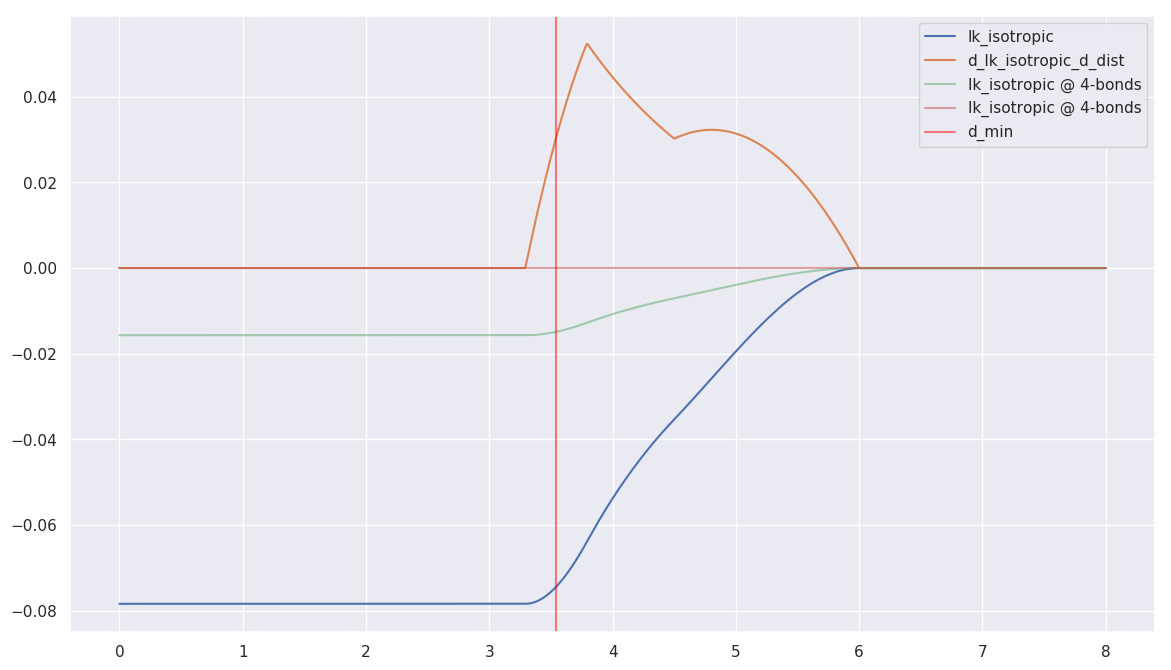

In [13]:
def eval_lk(ds, bpl, i, j):
    return ignore_unused_kwargs(lk_isotropic)(
        ds,
        bpl,
        *params(i, j)
    )


ds = numpy.linspace(0, 8, 1000)

pylab.plot(ds, lk_isotropic(ds, 5, **params(i, j)), label="lk_isotropic")
pylab.plot(
    ds,
    d_lk_isotropic_d_dist(
        ds,
        5,
        **params(i, j)),
    label="d_lk_isotropic_d_dist",
)

pylab.plot(ds, lk_isotropic(ds, 4, **params(i, j)), alpha=.5, label="lk_isotropic @ 4-bonds")
pylab.plot(ds, lk_isotropic(ds, 2, **params(i, j)), alpha=.5, label="lk_isotropic @ 4-bonds")

pylab.axvline(.89 * (i.lj_radius + j.lj_radius), color="red", alpha=.5, label="d_min")
pylab.legend(loc="best")